In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-5", temperature=0)

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY:  ········


In [4]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Doctor(BaseModel):
    name: str = Field(
        description="Name of the doctor."
    )
    qualifications: str = Field(
        description="Qualifications of the doctor",
    )
    specialization: str = Field(
        description="Specialization of the dcotor i.e., cardiologist, dermatologist, orthopedist, etc.",
    )
    experience: int = Field(
        description="Number of years of work experience of the doctor"
    )
    description: str = Field(
        description="Description of the doctor's place of work, achievements, etc.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nQualifications: {self.qualifications}\nSpecialization: {self.specialization}\nExperience: {self.experience}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    doctors: List[Doctor] = Field(
        description="Comprehensive list of doctors with their specializations, place of work and qualifications.",
    )

class GenerateDoctorsState(TypedDict):
    symptom: str 
    max_doctors: int 
    human_feedback: str 
    doctors: List[Doctor]

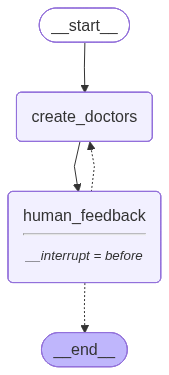

In [5]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

doctor_instructions="""You are tasked with creating a set of Doctors. Follow these instructions carefully:

1. First, take a look at the symptom: {symptom}
        
2. Examine any feedback that has been optionally provided to guide creation of the doctor personas: 
        
{human_feedback}
    
3. Determine the most suitable specialists who can diagnose the symptom {symptom}.
                    
4. Pick the top {max_doctors} specialists most suited for the symptom {symptom}.

5. Assign one doctor for each specialization."""

def create_doctors(state: GenerateDoctorsState):
    
    """ Create doctors """
    
    symptom=state['symptom']
    max_doctors=state['max_doctors']
    human_feedback=state.get('human_feedback', '')
        
    structured_llm = llm.with_structured_output(Perspectives)

    system_message = doctor_instructions.format(symptom=symptom,
                                                            human_feedback=human_feedback, 
                                                            max_doctors=max_doctors)
 
    doctors = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the list of doctors.")])

    return {"doctors": doctors.doctors}

def human_feedback(state: GenerateDoctorsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateDoctorsState):
    """ Return the next node to execute """

    human_feedback=state.get('human_feedback', None)
    if human_feedback:
        return "create_doctors"
    
    return END
 
builder = StateGraph(GenerateDoctorsState)
builder.add_node("create_doctors", create_doctors)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_doctors")
builder.add_edge("create_doctors", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_doctors", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [6]:
# Creating a list of doctors
max_doctors = 3 
symptom = "I am having a pain in my lungs"
thread = {"configurable": {"thread_id": "1"}}
doctors=()
for event in graph.stream({"symptom":symptom,"max_doctors":max_doctors,}, thread, stream_mode="values"):
    doctors = event.get('doctors', '')
    if doctors:
        for doctor in doctors:
            print(f"Name: {doctor.name}")
            print(f"Experience(in years): {doctor.experience}")
            print(f"Qualification: {doctor.qualifications}")
            print(f"Specialization: {doctor.specialization}")
            print(f"Description: {doctor.description}")
            print("-" * 50)  

Name: Dr. Maya R. Patel
Experience(in years): 14
Qualification: MD, FCCP (Pulmonary & Critical Care Medicine)
Specialization: Pulmonologist
Description: Pulmonary and Critical Care specialist at Metropolitan Respiratory & Critical Care Center. Leads the pleural disease clinic; expertise in evaluating pleuritic chest pain, pneumonia, pulmonary embolism, pneumothorax, and interstitial lung diseases. Proficient in bedside ultrasound, bronchoscopy, and interpretation of pulmonary function tests and chest CT.
--------------------------------------------------
Name: Dr. Daniel K. Morgan
Experience(in years): 16
Qualification: MD, FACC
Specialization: Cardiologist
Description: Consultant Cardiologist at Riverside Heart Institute. Focuses on chest pain assessment and ruling out cardiac causes such as ischemia, pericarditis, and aortic pathology; runs a rapid-access chest pain service; skilled in ECG interpretation, stress testing, echocardiography, and coronary CT angiography.
----------------

In [7]:
state = graph.get_state(thread)
state.next

('human_feedback',)

In [8]:
graph.update_state(thread, {"human_feedback": 
                            "Add a Lung cancer specialist"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0cc693-f9c6-6c74-8002-3993e02446c1'}}

In [9]:
for event in graph.stream(None, thread, stream_mode="values"):
    doctors = event.get('doctors', '')
    if doctors:
        for doctor in doctors:
            print(f"Name: {doctor.name}")
            print(f"Experience(in years): {doctor.experience}")
            print(f"Qualification: {doctor.qualifications}")
            print(f"Specialization: {doctor.specialization}")
            print(f"Description: {doctor.description}")
            print("-" * 50)

Name: Dr. Maya R. Patel
Experience(in years): 14
Qualification: MD, FCCP (Pulmonary & Critical Care Medicine)
Specialization: Pulmonologist
Description: Pulmonary and Critical Care specialist at Metropolitan Respiratory & Critical Care Center. Leads the pleural disease clinic; expertise in evaluating pleuritic chest pain, pneumonia, pulmonary embolism, pneumothorax, and interstitial lung diseases. Proficient in bedside ultrasound, bronchoscopy, and interpretation of pulmonary function tests and chest CT.
--------------------------------------------------
Name: Dr. Daniel K. Morgan
Experience(in years): 16
Qualification: MD, FACC
Specialization: Cardiologist
Description: Consultant Cardiologist at Riverside Heart Institute. Focuses on chest pain assessment and ruling out cardiac causes such as ischemia, pericarditis, and aortic pathology; runs a rapid-access chest pain service; skilled in ECG interpretation, stress testing, echocardiography, and coronary CT angiography.
----------------

In [10]:
further_feedack = None
graph.update_state(thread, {"human_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0cc695-0bcd-6b6f-8004-573a29d6054b'}}

In [11]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [12]:
final_state = graph.get_state(thread)
doctors = final_state.values.get('doctors')

In [13]:
final_state.next

()

In [14]:
for doctor in doctors:
    print(f"Name: {doctor.name}")
    print(f"Experience(in years): {doctor.experience}")
    print(f"Qualification: {doctor.qualifications}")
    print(f"Specialization: {doctor.specialization}")
    print(f"Description: {doctor.description}")
    print("-" * 50) 

Name: Dr. Aisha Mehta
Experience(in years): 18
Qualification: MBBS, MD (Internal Medicine), DM (Pulmonology), FCCP
Specialization: Pulmonologist
Description: Head of Pulmonary Medicine at City Lung & Sleep Center. Specializes in evaluation of pleuritic chest pain, pneumonia, pulmonary embolism workups, and pleural diseases. Leads a multidisciplinary chest clinic with same-day spirometry and ultrasound-guided pleural procedures; widely published on pleurisy management.
--------------------------------------------------
Name: Dr. Daniel Ruiz
Experience(in years): 16
Qualification: MD, DM (Medical Oncology), ESMO Certified
Specialization: Thoracic Oncologist (Lung Cancer Specialist)
Description: Director of the Lung Cancer Program at Riverside Cancer Center. Focuses on early diagnosis and comprehensive care of lung malignancies, including targeted therapies and immuno-oncology. Runs a rapid-assessment clinic for suspicious chest symptoms and chairs weekly thoracic tumor boards.
----------

In [23]:
# planning on arriving at result with the help of debates between the professionals.
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class DebateState(MessagesState):
    max_num_turns: int 
    context: Annotated[list, operator.add] 
    doctor1: Doctor
    doctor2: Doctor
    doctor3: Doctor
    debate: str 
    sections: list 

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [29]:
debate_instructions = """You are a doctor tasked who has to diagnose a patient's symptoms. 

Your goal is to justify your approach and try to convince the other doctors why your way is the best. Be open to all ideas and decide the best way.

1. Take turns: Have a back and forth with the other specialists on how to diagnose and treat the symptom.
        
2. Specific: Insights that avoid generalities and include specific examples from your field.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then make your case.

Continue to ask questions to drill down and refine your treatment plan for the patient.

You are to make judgments based on just the symptoms of the patient, if there is any uncertainty (i.e. gender, age, history), you are to provide answers for all cases to be as all-encompassing as possible
        
When you are satisfied with your plan, complete the debate with: "Thank you!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_discussion(state: DebateState):
    """ Node to generate a discussion """

    doctor1 = state["doctor1"]
    doctor2 = state["doctor2"]
    doctor3 = state["doctor3"]
    messages = state["messages"]
 
    system_message = debate_instructions.format(goals={doctor1.persona,doctor2.persona,doctor3.persona})
    sentence = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    return {"messages": [sentence]}

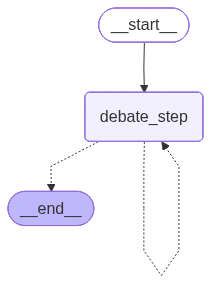

In [30]:
# testing out a smaple debate by making a temporary graph for debate

builder = StateGraph(DebateState)

builder.add_node("debate_step", generate_discussion)
builder.add_edge(START, "debate_step")
def should_continue(state):
    # stop if "Thank you!" appears OR turns exceeded
    last_message = state["messages"][-1].content.lower()

    if "thank you" in last_message:
        return END
    if len(state["messages"]) >= state["max_num_turns"]:
        return END
    return "debate_step"
builder.add_conditional_edges(
    "debate_step",
    should_continue,
    ["debate_step", END]
)

memory = MemorySaver()
graph = builder.compile(interrupt_before=[], checkpointer=memory)

from IPython.display import Image, display

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [31]:
# Input
doctor1=doctors[0]
doctor2=doctors[1]
doctor3=doctors[2]
max_num_turns = 15
topic = "Treating the symptom"
thread = {"configurable": {"thread_id": "2"}}
initial_state = {
    "messages": [
        {"role": "user", "content": "The patient has pleuritic chest pain and cough."}
    ],
    "doctor1": doctor1,
    "doctor2": doctor2,
    "doctor3": doctor3,
    "context": [],
    "max_num_turns": max_num_turns,
    "debate": topic,
    "sections": []
}


# Run the graph until the first interruption
for event in graph.stream(initial_state, thread, stream_mode="values"):
    if "messages" in event:
        # Print the newest message in the debate
        print("\n----------------------------------------------")
        print(event["messages"][-1].content)


----------------------------------------------
The patient has pleuritic chest pain and cough.

----------------------------------------------
I’m Dr. Daniel Ruiz, thoracic oncologist. Thanks for joining this rapid consult. Pleuritic chest pain with cough is a classic “don’t-miss” presentation. My bias is to protect the patient from life‑threats first (pulmonary embolism, pneumothorax, pneumonia/empyema, pericarditis), then quickly identify those with malignant or TB-related pleural disease. I propose a same‑day, protocolized pathway that minimizes delays and unnecessary radiation, but escalates instantly when red flags are present.

Dr. Aisha Mehta (Pulmonology): Agreed. Pleuritic pain implies pleural or pericardial inflammation, or lung parenchymal strain. The workup rises and falls on three things we can do right now: vital signs, focused history, and a chest X‑ray with bedside lung/pleural ultrasound. I want to triage immediately:

Red flags that mandate emergency care now
- Hypox